# 线性系统脉冲响应辨识

## 维纳霍普(Wiener-Hopf)方程

$$
R_{uz}(\tau) = \int_0^\infty g(\lambda) R_{uu} (\tau- \lambda) d\lambda
$$

其中$R_{uz}$为信号$u,z$的互相关函数,$R_{uu}$为自相关函数，有：

$$
\begin{align*}
R_{uz}(\tau) &= \lim_{T \to \infty} \frac{1}{T} \int_0^T z(t) u(t- \tau) dt \\
R_{uu}(\tau) &= \lim_{T \to \infty} \frac{1}{T} \int_0^T z(t) z(t- \tau) dt 
\end{align*}
$$

由Wiener-Hopf方程可知，对一个脉冲响应函数为$g(t)$的线性系统输入信号$u(t)$的自相关函数，则它输出与$g$与$u$的互相关函数$R_{ug}$。
当然如果输入$u(t)$本身，它返回$g$与$u$的卷积。

对于像这样的的系统：

<img src="img/uxi.png">

我们可以表明$R_{uz}$与$R_{uy}$是相等的，若$u(t)$与$\xi(t)$不相关（当然这里这两个是确定信号，完全不相关貌似有点难），
、从而可以直接消除这种噪声的影响:

$$
\begin{align*}
R_{uy} &= \lim_{T \to \infty} \frac{1}{T} \int_0^T y(t) u(t- \tau) dt \\
       &= \lim_{T \to \infty} \frac{1}{T} \int_0^T (z(t) + \xi(t)) u(t- \tau) dt \\
       &= R_{uz} + R_{u\xi} \\
       &= R_{uz}
\end{align*}
$$

由于$\xi$在一个特定时间生成的确定序列是随机的，我们可以考虑如果我们输入一些诸如方波，白噪声之类的序列与它的互相关函数是否足够接近0，
在一些样本中。(下述例子是离散的，可以看成一些“连续”方波在算互相关)

In [18]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
def corr(x,y,k=None):
    n = x.shape[0]
    if k is None:
        k = n//2
    R = np.empty(k)
    R[0] = np.sum(x*y)/k
    for rho in range(1, k):
        R[rho] = np.sum(x[:-rho] * y[rho:])/(n-rho)
    return R

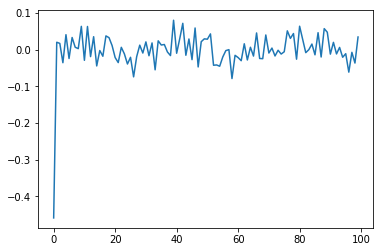

In [20]:
plt.plot(corr(np.random.randn(1000),np.random.randn(1000),k=100))

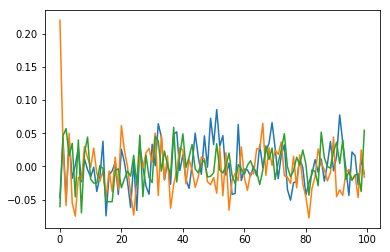

In [21]:
for i in range(3):
    plt.plot(corr(np.random.randn(1000),np.random.randn(1000),k=100))

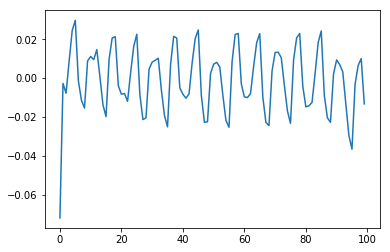

In [22]:
sq = np.tile(np.repeat([1.,-1.],10),50)
plt.plot(corr(sq, np.random.randn(1000),k=100))

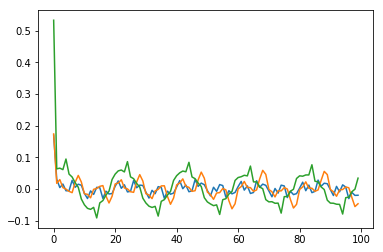

In [23]:
for i in range(3):
    sq = np.tile(np.repeat([1.,-1.],10),50)
    plt.plot(corr(sq, np.random.randn(1000),k=100))

可以看出虽然样本互相关函数总偏离于0一些，但是在$\xi$随机生成机制与$u(t)$无关情况下，其总围绕$0$且偏离不会太大。
不难想象也有生成机制有关的情况：

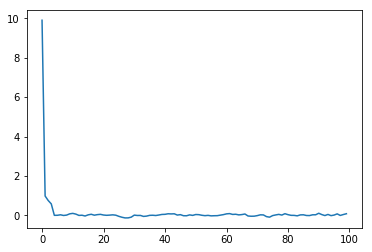

In [24]:
w1 = np.random.randn(1000)
w2 = np.empty(1000)
w2[0:3] = 0.0
for i in range(3,1000):
    w2[i] = w1[i] + w1[i-1] + 0.8*w1[i-2] + 0.6* w1[i-3]
plt.plot(corr(w1, w2,k=100))

考虑输入白噪声$u(t)$，其自相关函数为：

$$
R_{uu}(\tau) = K \delta (\tau)
$$

代入Wiener-Hopf方程可知：

$$
R_{uz}(\tau) = \int_0^\infty g(\lambda) K \delta (\tau - \lambda) = g(\tau)
$$

当然这个并不是白噪声的样本自相关函数，而只是它的期望，实际上输入的白噪声因为波动还是会和系统噪声的白噪声有着某种相互关系，
对估计结果产生波动。

如此若我们能计算出R_{uz}(\tau)的值，我们就自动得到对应点上$g(\tau)$的值。

如果我们用上面$randn$之类的白噪声，其实相当于生成了一些特定宽度$\Delta$，长度为独立正态分布的方波进入系统。那么自相关函数应该在开始
的一个$\Delta$长度内还比较大，从第二个$\Delta$长度开始才开始极速衰减。另一方面我们的白噪声序列也是有限长的，从而：

TODO:...



## M序列

M序列是一种伪随机序列，N级M序列不断从一个N维的取值为(1,-1)的向量转化为另一个这样的向量，
其方式是计算最后一位乘反馈级K位（若把-1看成1,1看成0则相当于xor运算），然后把这个数送到第一个数，
原先的第一个数到倒数第二个数往后推一格。这么做最多产生$2^{n}$个序列后开始循环，把一个循环重复若干遍后就是一个伪随机M序列。

In [25]:
def M_seq(x0, k, trace=False):
    x = x0.copy()
    x_list= []
    while True:
        x_list.append(x.copy())
        y = x[-1] * x[k]
        x[1:] = x[:-1]
        x[0] = y
        if np.allclose(x0,x):
            break
    x_array = np.array(x_list)
    if trace:
        return x_array
    return x_array[:,-1]

In [26]:
M_seq(np.array([-1,-1,-1,-1]), 0, trace=True)

array([[-1, -1, -1, -1],
       [ 1, -1, -1, -1],
       [-1,  1, -1, -1],
       [ 1, -1,  1, -1],
       [-1,  1, -1,  1],
       [-1, -1,  1, -1],
       [ 1, -1, -1,  1],
       [ 1,  1, -1, -1],
       [-1,  1,  1, -1],
       [ 1, -1,  1,  1],
       [ 1,  1, -1,  1],
       [ 1,  1,  1, -1],
       [-1,  1,  1,  1],
       [-1, -1,  1,  1],
       [-1, -1, -1,  1]])

In [27]:
M_seq(np.array([-1,-1,-1,-1]), 1, trace=True)

array([[-1, -1, -1, -1],
       [ 1, -1, -1, -1],
       [ 1,  1, -1, -1],
       [-1,  1,  1, -1],
       [-1, -1,  1,  1],
       [-1, -1, -1,  1]])

In [28]:
M_seq(np.array([-1,-1,-1,-1]), 0)

array([-1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1,  1,  1])

### 一个仿真

<img src="img/disc.png">

上图可以以脉冲传递函数的形式写做：

$$
y(z) = \frac{z^{-1}(1-0.6z^{-1})}{1-1.3z^{-1}+0.4z^{-2}}u(z) + \frac{1}{1-1.3z^{-1}+0.4^{-2}} \lambda \omega(z)
$$

两边同乘再Z反变换（利用z变换平移性质$f(t-nT) \to f(z)z^{-n}$）

$$
\begin{align*}
(1-1.3z^{-1}+0.4z^{-2})y(z) &= z^{-1}(1-0.6z^{-1}) u(z) + \lambda \omega(z) \\
y(z)-1.3z^{-1}y(z)+0.4z^{-2}y(z) &= z^{-1}u(z)-0.6z^{-2}u(z) + \lambda \omega(z) \\
\mathcal{Z}^{-1}(y(z)-1.3z^{-1}y(z)+0.4z^{-2}y(z)) &= \mathcal{Z}^{-1}(z^{-1}u(z)-0.6z^{-2}u(z) + \lambda \omega(z)) \\
y(t) - 1.3y(t-T) +0.4 y(t-2T) &= u(t-T) -0.6 u(t-2T) + \lambda \omega(t)
\end{align*}
$$

若设$T=1$，则可记为

$$
y(t)   = 1.3y(t-1) -0.4 y(t-2) +u(t-1) -0.6 u(t-2) + \lambda \omega(t)
$$

这里我们可以看出我们得要求噪声通过一个和对控制$u(t)$同分母的系统后才能在系统后面呈现简单的形式，这看起来并不自然，比如我们可能认为
它就是1，而不是一个同分母的传递函数。此时$y(t)$将于好几个$\omega(t-kT)$相关，类似ARMA模型和系统辨识中更一般的那个模型了。

In [29]:
lam = 0.05

#u = np.tile(M_seq(np.array([-1,-1,-1,-1]), 0),100)[:1000]
u = np.random.randn(1000)
omega = np.random.randn(1000) 
y = np.empty(1000)
y[0] = y[1] = 0.
for t in range(2, 1000):
    y[t] = 1.3 * y[t-1] - 0.4 * y[t-2] + u[t-1] - 0.6 * u[t-2] + lam * omega[t]

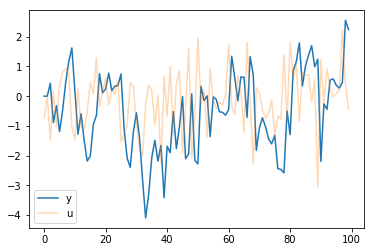

In [30]:
plt.plot(y[:100],label='y')
plt.plot(u[:100],label='u',alpha=0.3)
plt.legend()
plt.show()

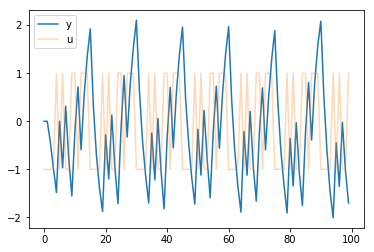

In [31]:
lam = 0.05

u = np.tile(M_seq(np.array([-1,-1,-1,-1]), 0),100)[:1000]
omega = np.random.randn(1000) 
y = np.empty(1000)
y[0] = y[1] = 0.
for t in range(2, 1000):
    y[t] = 1.3 * y[t-1] - 0.4 * y[t-2] + u[t-1] - 0.6 * u[t-2] + lam * omega[t]

plt.plot(y[:100],label='y')
plt.plot(u[:100],label='u',alpha=0.3)
plt.legend()
plt.show()

### 递推最小二乘估计

In [32]:
def rls_step(x, y, theta, P, rho=1.0):
    # K -> theta -> P
    # x: m
    # y: 1
    # theta: m
    # P m*m
    m = x.shape[0]
    K = (P @ x)/(rho + x @ P @ x)
    
    theta = theta + K * (y - x @ theta)
    I = np.eye(m)
    P = 1/rho * (P - np.outer(K, x @ P))
    return theta, P

def rls(X, Y, theta = None, P=None, alpha=1., rho=1.0, trace = False):
    n,m = X.shape
    if theta is None:
        theta = np.zeros(m)
    if P is None:
        P = alpha * np.eye(m)
    
    if trace:
        theta_list = [theta.copy()]
        P_list = [P.copy()]
    
    for i in range(n):
        theta, P = rls_step(X[i], Y[i], theta, P, rho = rho)
        if trace:
            theta_list.append(theta.copy())
            P_list.append(P.copy())
    if trace:
        return theta_list, P_list
    return theta, P

In [33]:
X = np.c_[y[1:-1],y[:-2],u[1:-1],u[:-2]]
Y = y[2:]
theta_list, P_list = rls(X,Y, theta = 0.001 * np.ones(4), P = 10**4 * np.eye(4), trace=True)

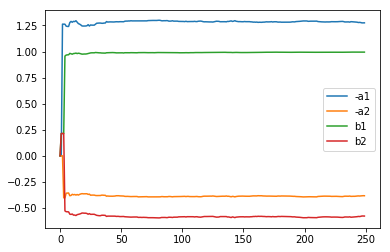

In [34]:
theta_array = np.array(theta_list)

plt.plot(theta_array[:250,0],label='-a1')
plt.plot(theta_array[:250,1],label='-a2')
plt.plot(theta_array[:250,2],label='b1')
plt.plot(theta_array[:250,3],label='b2')
plt.legend()
plt.show()

### 相关分析法（矩估计）

